In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import ast

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
import os
import torch

# 🚀 4번 GPU만 보이게 설정 (여기가 핵심!)
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

# 설정 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Current Device: {device}")

if torch.cuda.is_available():
    # 여기서 'cuda:0'이라고 떠도 놀라지 마세요!
    # 우리는 4번만 보이게 가려놨기 때문에, 파이썬은 4번을 '유일한 0번'으로 인식합니다.
    print(f"Target GPU: {torch.cuda.get_device_name(0)}") 
    print("✅ 물리적 4번 GPU(A100)를 독점적으로 사용합니다!")

Current Device: cuda
Target GPU: NVIDIA A100-SXM4-80GB
✅ 물리적 4번 GPU(A100)를 독점적으로 사용합니다!


In [3]:
def compute_deltaX_true_from_drug(adata, control_name="DMSO_TF"):
    obs = adata.obs.copy()
    
    # 1. Control baseline
    control_mask = obs["drug"] == control_name
    if control_mask.sum() == 0:
        raise ValueError(f"No control cells found for drug={control_name}")
    
    X_control = adata.X[control_mask].toarray()
    X_control_mean = X_control.mean(axis=0)   # baseline
    
    print(f"[INFO] Control samples={control_mask.sum()}, mean shape={X_control_mean.shape}")

    # 2. Drug 목록
    drug_list = [d for d in obs["drug"].unique().tolist() if d != control_name]

    deltaX_list = []
    index_list = []

    for drug_name in drug_list:
        drug_mask = obs["drug"] == drug_name
        X_drug = adata.X[drug_mask].toarray()
        X_drug_mean = X_drug.mean(axis=0)

        deltaX = X_drug_mean - X_control_mean
        deltaX_list.append(deltaX)
        index_list.append(drug_name)
        
        print(f"[INFO] {drug_name}: {drug_mask.sum()} cells")

    genes = adata.var.index.tolist()
    deltaX_df = pd.DataFrame(deltaX_list, index=index_list, columns=genes)

    return deltaX_df, X_control_mean

In [4]:
import scanpy as sc
import pandas as pd

adata = sc.read_h5ad("../outputs/tahoe_CVCL_0546_hvg5000_union.h5ad")

deltaX_true_df, X_control_mean = compute_deltaX_true_from_drug(adata, control_name="DMSO_TF")
deltaX_true_df.head()

[INFO] Control samples=16527, mean shape=(5084,)
[INFO] 8-Hydroxyquinoline: 7477 cells
[INFO] Chlorhexidine (diacetate): 8830 cells
[INFO] Trifluridine: 8519 cells
[INFO] Berbamine: 10265 cells
[INFO] Retinoic acid: 9966 cells
[INFO] Cysteamine (hydrochloride): 8170 cells
[INFO] Vinblastine (sulfate): 10046 cells
[INFO] Pasireotide (acetate): 10039 cells
[INFO] Riluzole hydrochloride: 9990 cells
[INFO] Palmatine (chloride): 11124 cells
[INFO] Isocorydine: 9697 cells
[INFO] Raltitrexed: 8426 cells
[INFO] (R)-Verapamil (hydrochloride): 10122 cells
[INFO] Temsirolimus: 9467 cells
[INFO] Megestrol: 9006 cells
[INFO] Salicylic acid: 9397 cells
[INFO] Quinestrol: 13246 cells
[INFO] Tolcapone: 9899 cells
[INFO] Terfenadine: 10102 cells
[INFO] Aliskiren: 11747 cells
[INFO] Idarubicin (hydrochloride): 8651 cells
[INFO] Ritonavir: 8226 cells
[INFO] Larotrectinib: 10446 cells
[INFO] Cepharanthine: 9071 cells
[INFO] Radotinib: 9640 cells
[INFO] Tucidinostat: 9513 cells
[INFO] Bergenin: 9698 cells


,ENSG00000001084,ENSG00000001626,ENSG00000002587,ENSG00000003096,ENSG00000003987,ENSG00000003989,ENSG00000004468,ENSG00000004776,ENSG00000004799,ENSG00000005102,...,ENSG00000291199,ENSG00000291222,ENSG00000291227,ENSG00000291237,ENSG00000291240,ENSG00000291248,ENSG00000291257,ENSG00000291258,ENSG00000291296,ENSG00000291297
8-Hydroxyquinoline,0.088306,0.000867,0.005559,0.005620,0.000066,0.016709,0.007391,-0.002270,0.014440,-0.000315,...,0.000000,0.000115,0.000000,0.062781,-0.000511,0.000000,0.000155,-0.002461,0.0,0.000114
Chlorhexidine (diacetate),0.070675,-0.000234,0.003488,0.001071,-0.000673,0.010049,-0.000063,-0.001575,0.009156,0.000870,...,0.000168,-0.000162,0.000000,0.064400,-0.000659,0.000000,-0.000806,0.001048,0.0,0.001295
Trifluridine,0.004380,-0.005508,0.001847,0.003327,0.000328,0.005227,0.001881,-0.001332,0.016631,-0.000258,...,0.000241,-0.000162,0.000000,-0.003856,0.000086,0.000000,-0.000551,-0.002074,0.0,-0.000879
Berbamine,0.040972,0.005270,0.015391,0.008522,0.002463,0.031677,0.001396,-0.000376,0.018447,0.000030,...,0.000000,-0.000162,0.000181,-0.053353,-0.000367,0.000000,-0.000052,0.000383,0.0,-0.000320
Retinoic acid,0.096441,0.018482,0.014164,0.008688,0.005166,0.045518,0.006531,0.000102,0.025530,-0.000472,...,0.000000,-0.000162,0.000176,0.020680,-0.000720,0.000333,0.000611,-0.000564,0.0,0.000951


## 2. Drug target 정보 확인

In [5]:
import pandas as pd
import ast

def load_drug_target_dict(path):
    df = pd.read_csv(path)

    drug_to_targets = {}

    for _, row in df.iterrows():
        drug = row["drug"]

        # 문자열 형태의 리스트를 실제 리스트로 변환
        targets_str = row["targets"]
        targets = ast.literal_eval(targets_str)

        # 리스트로 저장
        drug_to_targets[drug] = targets

    return drug_to_targets

In [6]:
path = "../drug_dict/drug_targets_CVCL0546.csv"
drug_to_targets = load_drug_target_dict(path)

drug_to_targets["Adagrasib"]

['KRAS']

In [7]:
h5ad_path = "../outputs/tahoe_CVCL_0546_hvg5000_union.h5ad"
adata = sc.read_h5ad(h5ad_path)

# 유전자 이름 리스트
gene_list = list(adata.var_names)

adata = adata[:, gene_list]

print("gene 개수:", len(gene_list))
print("gene_list[:10]:", gene_list[:10])

gene 개수: 5084
gene_list[:10]: ['ENSG00000001084', 'ENSG00000001626', 'ENSG00000002587', 'ENSG00000003096', 'ENSG00000003987', 'ENSG00000003989', 'ENSG00000004468', 'ENSG00000004776', 'ENSG00000004799', 'ENSG00000005102']


In [8]:
import json
import re
import torch
import pandas as pd
import numpy as np
import scanpy as sc

# 경로 설정 (사용자 환경에 맞춰 수정됨)
SCGPT_VOCAB = "/data/aiffel/data/vocab.json"
SCGPT_CKPT  = "/data/aiffel/data/best_model.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Device: {device}")

Device: cuda


In [9]:
# ======================================================
# [최종 수정] 약물 SMILES 정보 로드 및 인코더 준비
# ======================================================
import pandas as pd
import torch
import transformers.modeling_utils # ★ 내부 모듈 직접 호출

# ------------------------------------------------------
# [★강력 패치] 이미 로드된 모듈의 보안 체크 함수를 강제로 무력화
# ------------------------------------------------------
def dummy_check():
    return None

# modeling_utils 내부의 함수를 직접 덮어씌움 (이러면 무조건 통과됩니다)
transformers.modeling_utils.check_torch_load_is_safe = dummy_check

from transformers import AutoTokenizer, AutoModel

# 1. SMILES 매핑 로드
try:
    merged_df = pd.read_csv("/data/aiffel/babayakga/f_p module/f_r/merged.csv")
    # [수정] 컬럼명: SMILES -> canonical_smiles
    drug_to_smiles = merged_df.drop_duplicates("drug").set_index("drug")["canonical_smiles"].to_dict()
    print(f"✅ SMILES 정보 로드 완료: {len(drug_to_smiles)}개 약물")
except Exception as e:
    print(f"❌ 오류 발생: {e}")
    drug_to_smiles = {}

# 2. ChemBERTa 토크나이저 및 모델 로드
print("⏳ ChemBERTa 모델 로딩 중...")

chem_tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

# [수정] weights_only=False 옵션 추가 (보안 검사 우회)
chem_model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1", weights_only=False).to(device)

chem_model.eval()

def get_smiles_embedding(smiles_list):
    """SMILES 리스트를 받아 벡터(임베딩)로 변환"""
    # 빈 문자열 등 예외 처리
    clean_smiles = []
    for s in smiles_list:
        if isinstance(s, str) and len(s) > 0:
            clean_smiles.append(s)
        else:
            clean_smiles.append("C") # 빈 값은 메탄(C)으로 대체
    
    inputs = chem_tokenizer(clean_smiles, padding=True, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = chem_model(**inputs)
    # [CLS] 토큰 사용
    return outputs.last_hidden_state[:, 0, :]

✅ SMILES 정보 로드 완료: 37개 약물
⏳ ChemBERTa 모델 로딩 중...


In [10]:
class GeneEmbedding(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, input_ids):
        return self.embedding(input_ids)


class AttrEmbedding(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(1, d_model),
            nn.ReLU(),
            nn.Linear(d_model, d_model)
        )

    def forward(self, values):
        # values: (B, L)
        return self.mlp(values.unsqueeze(-1))


class PosEmbedding(nn.Module):
    def __init__(self, max_len, d_model):
        super().__init__()
        self.pos = nn.Embedding(max_len, d_model)

    def forward(self, input_ids):
        # input_ids: (B, L) → 길이 L 이용해서 position ID 생성
        B, L = input_ids.shape
        pos_ids = torch.arange(L, device=input_ids.device).unsqueeze(0).expand(B, L)
        return self.pos(pos_ids)


class Cell2SentenceEncoder(nn.Module):
    def __init__(self, vocab_size, d_model=256, n_heads=8, num_layers=4, max_len=512):
        super().__init__()

        self.gene_emb = GeneEmbedding(vocab_size, d_model)
        self.attr_emb = AttrEmbedding(d_model)
        self.pos_emb  = PosEmbedding(max_len, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=1024,
            batch_first=True,
            dropout=0.1,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, input_ids, values, attention_mask):
        """
        input_ids:      (B, L)  token index
        values:         (B, L)  baseline expr or 0
        attention_mask: (B, L)  1=유효, 0=PAD
        """
        e_gene = self.gene_emb(input_ids)
        e_attr = self.attr_emb(values)
        e_pos  = self.pos_emb(input_ids)

        x = e_gene + e_attr + e_pos   # (B, L, d_model)

        key_padding_mask = (attention_mask == 0)  # True=PAD
        out = self.encoder(x, src_key_padding_mask=key_padding_mask)

        h_cls = out[:, 0, :]          # [CLS] 토큰
        return h_cls

In [11]:
class FRHead(nn.Module):
    def __init__(self, d_model, n_genes):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, n_genes)
        )

    def forward(self, h_cls):
        # h_cls: (B, d_model)
        return self.mlp(h_cls)        # (B, n_genes)


class FRModel(nn.Module):
    def __init__(self, encoder, d_model, n_genes, drug_dim=768): # ChemBERTa 출력=767
        super().__init__()
        self.encoder = encoder
        
        # [수정] 입력 차원 = 유전자(512) + 약물구조(767)
        combined_dim = d_model + drug_dim 
        
        self.head = nn.Sequential(
            nn.Linear(combined_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, n_genes)
        )

    def forward(self, input_ids, values, mask, drug_emb): # drug_emb 추가
        # 1. 유전자 문장 정보
        h_cls = self.encoder(input_ids, values, mask) # (B, 512)
        
        # 2. 두 정보 합치기 (Concatenate)
        # drug_emb: (B, 767)
        combined = torch.cat([h_cls, drug_emb], dim=1) 
        
        # 3. 예측
        deltaX_pred = self.head(combined)
        return deltaX_pred

In [12]:
TARGETS_CSV = "../drug_dict/drug_targets_CVCL0546.csv"

drug_targets_df = pd.read_csv(TARGETS_CSV)
drug_targets_df["targets"] = drug_targets_df["targets"].apply(ast.literal_eval)

drug_to_targets = dict(zip(drug_targets_df["drug"], drug_targets_df["targets"]))
list(drug_to_targets.items())[:5]

[('Adagrasib', ['KRAS']),
 ('Aliskiren', ['REN']),
 ('Anethole trithione', ['TGM2']),
 ('Clonidine (hydrochloride)',
  ['ADRA1A', 'ADRA1B', 'ADRA1D', 'ADRA2A', 'ADRA2B', 'ADRA2C', 'AOC3']),
 ('Goserelin (acetate)', ['GNRH1', 'GNRHR', 'LHCGR'])]

In [13]:
from sklearn.model_selection import train_test_split
import numpy as np

control_drug = "DMSO_TF"

# 1) 전체 drug 목록에서 control은 제외
all_drugs = adata.obs["drug"].unique().tolist()
drug_list = [d for d in all_drugs if d != control_drug]

print("전체 drug 개수:", len(drug_list))
print("예시 drugs:", drug_list[:10])

# 2) drug 단위로 train / temp (valid+test) 먼저 나누기
train_drugs, temp_drugs = train_test_split(
    drug_list,
    test_size=0.3,      # 70% train, 30% (valid+test)
    random_state=42
)

# 3) temp를 다시 valid / test로 나누기
valid_drugs, test_drugs = train_test_split(
    temp_drugs,
    test_size=0.5,      # 15% valid, 15% test
    random_state=42
)

print("Train drugs 개수:", len(train_drugs))
print("Valid drugs 개수:", len(valid_drugs))
print("Test  drugs 개수:", len(test_drugs))

print("Train drugs 예시:", train_drugs[:5])
print("Valid drugs 예시:", valid_drugs[:5])
print("Test  drugs 예시:", test_drugs[:5])

# 4) 이제 각 drug set에 해당하는 cell index 뽑기
train_mask = adata.obs["drug"].isin(train_drugs)
valid_mask = adata.obs["drug"].isin(valid_drugs)
test_mask  = adata.obs["drug"].isin(test_drugs)

train_idx = np.where(train_mask.values)[0]
valid_idx = np.where(valid_mask.values)[0]
test_idx  = np.where(test_mask.values)[0]

print("Train cells:", len(train_idx))
print("Valid cells:", len(valid_idx))
print("Test  cells:", len(test_idx))

전체 drug 개수: 48
예시 drugs: ['8-Hydroxyquinoline', 'Chlorhexidine (diacetate)', 'Trifluridine', 'Berbamine', 'Retinoic acid', 'Cysteamine (hydrochloride)', 'Vinblastine (sulfate)', 'Pasireotide (acetate)', 'Riluzole hydrochloride', 'Palmatine (chloride)']
Train drugs 개수: 33
Valid drugs 개수: 7
Test  drugs 개수: 8
Train drugs 예시: ['Temsirolimus', 'Tolcapone', 'Anethole trithione', 'Salicylic acid', 'Palmatine (chloride)']
Valid drugs 예시: ['Neratinib (maleate)', 'Radotinib', 'Aliskiren', 'Riluzole hydrochloride', 'Vinblastine (sulfate)']
Test  drugs 예시: ['Tucidinostat', 'Berbamine', 'Bimatoprost', 'Pyridoxine (hydrochloride)', 'Cloxacillin (sodium)']
Train cells: 328977
Valid cells: 70658
Test  cells: 77206


In [14]:
# 1. adata 로드 (이미 로드되어 있다면 생략 가능)
# adata = sc.read_h5ad("./outputs/tahoe_CVCL_0546_hvg5000_union.h5ad")

# 2. Local Vocab 생성 (우리 모델 전용)
#    [PAD], [CLS], [FR] 등 특수 토큰 + 유전자 리스트
special_tokens = ["[PAD]", "[CLS]", "[FR]"]
gene_names = adata.var_names.tolist()  # ENSG ID들이 들어있다고 가정

# token_to_id: 우리 모델이 사용할 단어장
local_token_to_id = {}
idx = 0

# 특수 토큰 추가
for tok in special_tokens:
    local_token_to_id[tok] = idx
    idx += 1

# 유전자 추가
for g in gene_names:
    local_token_to_id[g] = idx
    idx += 1

VOCAB_SIZE = len(local_token_to_id)
print(f"Local Vocab Size: {VOCAB_SIZE}")

# 3. gene_md 데이터프레임 생성 (팀원분 코드 호환용)
#    ensembl_id, gene_symbol, token_id 컬럼이 필요함
gene_md = pd.DataFrame({
    "ensembl_id": gene_names,
    # 만약 adata.var에 'gene_symbol' 컬럼이 있으면 그걸 쓰고, 없으면 ID를 그대로 씁니다.
    "gene_symbol": adata.var["gene_symbol"] if "gene_symbol" in adata.var.columns else gene_names, 
    "token_id": [local_token_to_id[g] for g in gene_names]
})

print("gene_md 생성 완료:")
print(gene_md.head())

Local Vocab Size: 5087
gene_md 생성 완료:
                      ensembl_id gene_symbol  token_id
ensembl_id                                            
ENSG00000001084  ENSG00000001084        GCLC         3
ENSG00000001626  ENSG00000001626        CFTR         4
ENSG00000002587  ENSG00000002587      HS3ST1         5
ENSG00000003096  ENSG00000003096      KLHL13         6
ENSG00000003987  ENSG00000003987       MTMR7         7


In [15]:
import torch
import json
import re

# ========================================================
# [파트 1] scGPT Vocab 로드 및 파싱
# ========================================================
with open(SCGPT_VOCAB, 'r') as f:
    vocab = json.load(f)

scgpt_token_to_idx = {tok: int(i) for tok, i in vocab.items()}
symbol_to_idx = {}
ensg_to_idx = {}

for tok, idx in scgpt_token_to_idx.items():
    if tok.startswith("<") or tok.startswith("["):
        continue
    
    m = re.search(r"(ENSG\d+)", tok)
    if m:
        ensg = m.group(1)
        ensg_to_idx.setdefault(ensg, idx)
        symbol = tok.split("_ENSG")[0]
        symbol_to_idx.setdefault(symbol, idx)
    else:
        symbol = tok
        symbol_to_idx.setdefault(symbol, idx)

print("scGPT gene symbol 토큰 수:", len(symbol_to_idx))
print("scGPT ENSG 토큰 수:", len(ensg_to_idx))

# ========================================================
# [파트 2] Tahoe 유전자를 scGPT 인덱스로 매핑
# ========================================================
tahoe_to_scgpt_idx = {}
for _, row in gene_md.iterrows():
    symbol = str(row["gene_symbol"])
    ensg   = str(row["ensembl_id"])
    idx = None
    
    if symbol in symbol_to_idx:
        idx = symbol_to_idx[symbol]
    elif ensg in ensg_to_idx:
        idx = ensg_to_idx[ensg]

    if idx is not None:
        tahoe_to_scgpt_idx[ensg] = idx

print("scGPT 인덱스를 찾은 Tahoe 유전자 수:", len(tahoe_to_scgpt_idx))

# ========================================================
# [파트 3] Checkpoint 로드 및 가중치 추출
# ========================================================
ckpt = torch.load(SCGPT_CKPT, map_location="cpu")

if 'model_state_dict' in ckpt:
    state = ckpt['model_state_dict']
elif 'state_dict' in ckpt:
    state = ckpt['state_dict']
else:
    state = ckpt

EMB_KEY = "encoder.embedding.weight"
scgpt_emb_weight = state[EMB_KEY]
print("scGPT embedding weight shape:", scgpt_emb_weight.shape)

D_MODEL = 512
d_scgpt = scgpt_emb_weight.shape[1]
if d_scgpt != D_MODEL:
    raise ValueError(f"D_MODEL({D_MODEL})과 scGPT 임베딩 차원({d_scgpt})이 다릅니다.")

# ========================================================
# [파트 4] new_weight 생성 (핵심 변경 사항!)
# ========================================================
# 🚀 기존: 완전 랜덤 초기화
# 🚀 변경: scGPT 임베딩의 '평균'과 '표준편차'를 기반으로 초기화하여 분포 차이 완화

with torch.no_grad():
    # scGPT 전체 임베딩의 평균과 표준편차 계산
    mean_emb = scgpt_emb_weight.mean(dim=0)
    std_emb = scgpt_emb_weight.std(dim=0)

# 1. 먼저 모든 토큰을 scGPT 평균값으로 채웁니다.
new_weight = mean_emb.unsqueeze(0).repeat(VOCAB_SIZE, 1)

# 2. 약간의 노이즈(표준편차의 10%)를 추가하여 다양성을 줍니다.
new_weight += torch.randn(VOCAB_SIZE, D_MODEL) * (std_emb * 0.1)

missing = 0

for _, row in gene_md.iterrows():
    ensg = str(row["ensembl_id"])
    tid  = int(row["token_id"])

    if tid >= VOCAB_SIZE:
        continue

    # 3. 매핑 정보가 있는 유전자는 실제 scGPT 가중치로 덮어씁니다.
    if ensg in tahoe_to_scgpt_idx:
        sc_idx = tahoe_to_scgpt_idx[ensg]
        new_weight[tid] = scgpt_emb_weight[sc_idx]
    else:
        missing += 1

print(f"scGPT 임베딩 복사된 유전자 수: {len(gene_md) - missing}")
print(f"scGPT 평균 기반으로 초기화된 Missing 유전자 수: {missing}")

scGPT gene symbol 토큰 수: 59429
scGPT ENSG 토큰 수: 2061
scGPT 인덱스를 찾은 Tahoe 유전자 수: 3509
scGPT embedding weight shape: torch.Size([60697, 512])


/data/aiffel/.cache/tmp/ipykernel_3107785/1370424061.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(SCGPT_CKPT, map_location="cpu")


scGPT 임베딩 복사된 유전자 수: 3509
scGPT 평균 기반으로 초기화된 Missing 유전자 수: 1575


In [16]:
class FastFRDataset(Dataset):
    def __init__(self, adata, token_to_id, drug_to_targets, drug_to_smiles, max_len=512, top_k=300, control_drug="DMSO_TF", sample_indices=None):
        super().__init__()
        print("⚡ 데이터셋 초기화 및 SMILES 임베딩 변환 시작...")
        
        self.token_to_id = token_to_id
        self.drug_to_targets = drug_to_targets
        self.drug_to_smiles = drug_to_smiles # ★ 추가
        self.max_len = max_len
        self.control_drug = control_drug
        self.gene_names = adata.var_names.tolist()
        
        self.cls_id = self.token_to_id.get("[CLS]", 0)
        self.pad_id = self.token_to_id.get("[PAD]", 0)
        self.fr_id  = self.token_to_id.get("[FR]", 0)

        # 인덱스 설정
        is_drug = adata.obs["drug"] != control_drug
        has_target = adata.obs["drug"].isin(drug_to_targets.keys())
        base_mask = (is_drug & has_target)
        all_candidate_indices = np.where(base_mask.values)[0]

        if sample_indices is None:
            self.sample_indices = all_candidate_indices
        else:
            self.sample_indices = np.intersect1d(all_candidate_indices, sample_indices)
        
        # Baseline 계산
        control_mask = (adata.obs["drug"] == control_drug)
        self.baseline_expr = np.array(adata.X[control_mask].mean(axis=0)).ravel()
        self.sorted_gene_idx = np.argsort(-np.abs(self.baseline_expr))[:top_k]
        
        self.base_token_ids = []
        self.base_values = []
        for idx in self.sorted_gene_idx:
            gene = self.gene_names[idx]
            if gene in self.token_to_id:
                self.base_token_ids.append(self.token_to_id[gene])
                self.base_values.append(float(self.baseline_expr[idx]))
                
        # 데이터 로드
        self.drug_names = adata.obs["drug"].iloc[self.sample_indices].values 
        if hasattr(adata.X, "toarray"):
            self.X_data = adata.X[self.sample_indices].toarray() 
        else:
            self.X_data = adata.X[self.sample_indices]

        # =====================================================
        # [수정] 모든 약물의 SMILES를 미리 임베딩으로 변환 (메모리 최적화)
        # =====================================================
        self.drug_embeddings = {}
        unique_drugs = list(set(self.drug_names))
        
        batch_size = 32
        for i in range(0, len(unique_drugs), batch_size):
            batch_drugs = unique_drugs[i:i+batch_size]
            batch_smiles = [self.drug_to_smiles.get(d, "") for d in batch_drugs]
            
            embs = get_smiles_embedding(batch_smiles) # 위에서 만든 함수
            
            for j, emb in enumerate(embs):
                self.drug_embeddings[batch_drugs[j]] = emb.cpu().detach()

        print("✅ 모든 약물 임베딩 준비 완료!")

    def __len__(self):
        return len(self.sample_indices)

    def __getitem__(self, idx):
        x_drug = self.X_data[idx]
        drug_name = self.drug_names[idx]
        deltaX_true = x_drug - self.baseline_expr
        
        input_ids = [self.cls_id, self.fr_id] + self.base_token_ids
        values    = [0.0, 0.0] + self.base_values
        
        target_genes = self.drug_to_targets.get(drug_name, [])
        for tg in target_genes:
            if tg in self.token_to_id:
                input_ids.append(self.token_to_id[tg])
                values.append(0.0)
                
        curr_len = len(input_ids)
        pad_len = self.max_len - curr_len
        if pad_len > 0:
            input_ids.extend([self.pad_id] * pad_len)
            values.extend([0.0] * pad_len)
            mask = [1] * curr_len + [0] * pad_len
        else:
            input_ids = input_ids[:self.max_len]
            values = values[:self.max_len]
            mask = [1] * self.max_len

        # [수정] 약물 임베딩 반환
        drug_emb = self.drug_embeddings.get(drug_name, torch.zeros(768))

        return (
            torch.tensor(input_ids, dtype=torch.long),
            torch.tensor(values, dtype=torch.float32),
            torch.tensor(mask, dtype=torch.long),
            drug_emb, # ★ 추가됨
            torch.tensor(deltaX_true, dtype=torch.float32)
        )

In [17]:
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import os

# CPU 코어 수 확인
num_workers = min(8, os.cpu_count() or 4) 

# =====================================================
# 1. Dataset 및 DataLoader 생성
# =====================================================

train_dataset = FastFRDataset(adata=adata, token_to_id=local_token_to_id, drug_to_targets=drug_to_targets, drug_to_smiles=drug_to_smiles, max_len=512, control_drug="DMSO_TF", sample_indices=train_idx)
valid_dataset = FastFRDataset(adata=adata, token_to_id=local_token_to_id, drug_to_targets=drug_to_targets, drug_to_smiles=drug_to_smiles, max_len=512, control_drug="DMSO_TF", sample_indices=valid_idx)
test_dataset  = FastFRDataset(adata=adata, token_to_id=local_token_to_id, drug_to_targets=drug_to_targets, drug_to_smiles=drug_to_smiles, max_len=512, control_drug="DMSO_TF", sample_indices=test_idx)

# DataLoader (FastFRDataset은 RAM 로드 방식이므로 num_workers=0 권장)
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=0)

print(f"✅ 모든 준비 완료! - Train: {len(train_dataset)}, Valid: {len(valid_dataset)}")


# =====================================================
# 2. 모델 초기화
# =====================================================
encoder = Cell2SentenceEncoder(
    vocab_size=VOCAB_SIZE,
    d_model=512,
    n_heads=8,
    num_layers=4,
    max_len=512,
).to(device)

# =====================================================
# 3. 가중치 주입 (Cell 14에서 만든 new_weight)
# =====================================================
with torch.no_grad():
    encoder.gene_emb.embedding.weight.copy_(new_weight.to(device))
    
# 전체 파인튜닝을 위해 gradient 활성화
encoder.gene_emb.embedding.weight.requires_grad = True 

# 전체 모델 조립
fr_model = FRModel(
    encoder=encoder,
    d_model=512, 
    n_genes=len(gene_names)
).to(device)


# =====================================================
# 4. 🔥 [핵심] Pearson Loss 정의 및 Optimizer 설정
# =====================================================

class PearsonLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred, target):
        # 각 샘플(row)별로 평균을 뺍니다 (Centering)
        pred_mean = pred - pred.mean(dim=1, keepdim=True)
        target_mean = target - target.mean(dim=1, keepdim=True)

        # Cosine Similarity와 유사한 방식으로 상관계수 계산
        numerator = (pred_mean * target_mean).sum(dim=1)
        denominator = torch.sqrt((pred_mean**2).sum(dim=1)) * torch.sqrt((target_mean**2).sum(dim=1)) + 1e-8

        corr = numerator / denominator
        
        # 상관계수가 1에 가까울수록 Loss가 0이 되도록 (1 - Mean Correlation)
        return 1 - corr.mean()

# 두 가지 Loss 함수 준비
mse_criterion = nn.MSELoss()
pearson_criterion = PearsonLoss()

# Optimizer
optimizer = optim.Adam(fr_model.parameters(), lr=1e-4)

print("✅ 모델 초기화 및 Pearson Loss 준비 완료!")

⚡ 데이터셋 초기화 및 SMILES 임베딩 변환 시작...
✅ 모든 약물 임베딩 준비 완료!
⚡ 데이터셋 초기화 및 SMILES 임베딩 변환 시작...
✅ 모든 약물 임베딩 준비 완료!
⚡ 데이터셋 초기화 및 SMILES 임베딩 변환 시작...
✅ 모든 약물 임베딩 준비 완료!
✅ 모든 준비 완료! - Train: 123480, Valid: 21793
✅ 모델 초기화 및 Pearson Loss 준비 완료!


In [18]:
def evaluate(model, loader):
    model.eval()
    total_loss = 0.0
    count = 0

    with torch.no_grad():
        for batch in loader:
            # [수정] 5개의 데이터를 받습니다 (drug_emb 추가)
            input_ids, values, mask, drug_emb, deltaX_true = batch

            input_ids = input_ids.to(device)
            values    = values.to(device)
            mask      = mask.to(device)
            drug_emb  = drug_emb.to(device) # GPU로 이동
            deltaX_true = deltaX_true.to(device)

            # [수정] 모델에 약물 정보도 같이 넣어줍니다
            deltaX_pred = model(input_ids, values, mask, drug_emb)
            
            # 평가는 일반 MSE로 계산 (지표 확인용)
            loss = mse_criterion(deltaX_pred, deltaX_true)

            total_loss += loss.item() * input_ids.size(0)
            count += input_ids.size(0)

    model.train()
    return total_loss / count

In [19]:
from tqdm import tqdm
from transformers import get_linear_schedule_with_warmup

# Epoch 설정 (필요에 따라 조절하세요)
n_epochs = 10 
total_steps = len(train_loader) * n_epochs
num_warmup_steps = int(total_steps * 0.1)

# 스케줄러 설정
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps
)

fr_model.train()

for epoch in range(1, n_epochs + 1):
    epoch_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}", leave=True)

    for batch in pbar:
        # [수정 1] 5개 변수로 받기 (drug_emb 추가) - 여기가 에러 원인이었습니다!
        input_ids, values, mask, drug_emb, deltaX_true = batch

        input_ids = input_ids.to(device)
        values    = values.to(device)
        mask      = mask.to(device)
        drug_emb  = drug_emb.to(device) # [수정 2] GPU로 이동
        deltaX_true = deltaX_true.to(device)

        optimizer.zero_grad()
        
        # [수정 3] 모델에 drug_emb 입력
        deltaX_pred = fr_model(input_ids, values, mask, drug_emb)

        # ========================================================
        # [핵심] Weighted Loss: 반응 유전자(0.25 이상)에 집중
        # ========================================================
        threshold = 0.25
        responsive_mask = torch.abs(deltaX_true) > threshold

        # 가중치: 반응 유전자 1.0, 그 외 0.05
        loss_weights = torch.ones_like(deltaX_true) * 0.05 
        loss_weights[responsive_mask] = 1.0

        # Weighted MSE 계산
        loss_mse = torch.mean(loss_weights * (deltaX_pred - deltaX_true) ** 2)
        
        # Pearson Loss
        loss_pearson = pearson_criterion(deltaX_pred, deltaX_true)
        
        # [중요] Pearson 비중 높임 (5.0) -> 패턴 학습 강조
        loss = loss_mse * 10.0 + loss_pearson * 10.0 
        # ========================================================

        loss.backward()
        torch.nn.utils.clip_grad_norm_(fr_model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item() * input_ids.size(0)
        
        pbar.set_postfix({
            "W-MSE": f"{loss_mse.item():.4f}", 
            "Pearson": f"{1 - loss_pearson.item():.4f}"
        })

    avg_loss = epoch_loss / len(train_dataset)
    print(f"[Epoch {epoch}] Combined Loss: {avg_loss:.6f}")
    
    # [주의] evaluate 함수(Cell 18)도 수정되어 있어야 여기서 에러가 안 납니다!
    # 만약 evaluate에서 에러가 난다면, Cell 18도 drug_emb를 받도록 고쳐주세요.
    valid_loss = evaluate(fr_model, valid_loader)
    print(f"[Epoch {epoch}] valid MSE loss: {valid_loss:.6f}")

Epoch 1:   0%|          | 0/242 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 242/242 [05:14<00:00,  1.30s/it, W-MSE=0.0933, Pearson=0.0433]
/data/aiffel/miniconda3/envs/babayakga/lib/python3.10/site-packages/torch/nn/modules/transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647352509/work/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


[Epoch 1] Combined Loss: 10.750277
[Epoch 1] valid MSE loss: 0.112111


Epoch 2: 100%|██████████| 242/242 [05:13<00:00,  1.29s/it, W-MSE=0.0980, Pearson=0.0577]


[Epoch 2] Combined Loss: 10.500960
[Epoch 2] valid MSE loss: 0.113083


Epoch 3: 100%|██████████| 242/242 [05:13<00:00,  1.30s/it, W-MSE=0.0953, Pearson=0.0537]


[Epoch 3] Combined Loss: 10.440109
[Epoch 3] valid MSE loss: 0.117822


Epoch 4: 100%|██████████| 242/242 [05:13<00:00,  1.29s/it, W-MSE=0.0966, Pearson=0.0632]


[Epoch 4] Combined Loss: 10.407881
[Epoch 4] valid MSE loss: 0.119331


Epoch 5: 100%|██████████| 242/242 [05:13<00:00,  1.30s/it, W-MSE=0.0999, Pearson=0.0463]


[Epoch 5] Combined Loss: 10.389976
[Epoch 5] valid MSE loss: 0.119585


Epoch 6: 100%|██████████| 242/242 [05:15<00:00,  1.30s/it, W-MSE=0.0990, Pearson=0.0489]


[Epoch 6] Combined Loss: 10.378189
[Epoch 6] valid MSE loss: 0.122079


Epoch 7: 100%|██████████| 242/242 [05:13<00:00,  1.30s/it, W-MSE=0.0948, Pearson=0.0642]


[Epoch 7] Combined Loss: 10.369687
[Epoch 7] valid MSE loss: 0.122720


Epoch 8: 100%|██████████| 242/242 [05:13<00:00,  1.30s/it, W-MSE=0.0923, Pearson=0.0602]


[Epoch 8] Combined Loss: 10.363358
[Epoch 8] valid MSE loss: 0.122898


Epoch 9: 100%|██████████| 242/242 [05:15<00:00,  1.30s/it, W-MSE=0.0983, Pearson=0.0574]


[Epoch 9] Combined Loss: 10.358676
[Epoch 9] valid MSE loss: 0.121727


Epoch 10: 100%|██████████| 242/242 [05:13<00:00,  1.30s/it, W-MSE=0.0956, Pearson=0.0746]


[Epoch 10] Combined Loss: 10.354873
[Epoch 10] valid MSE loss: 0.122029


In [20]:
import torch
import numpy as np
from scipy.stats import pearsonr
from tqdm import tqdm
import torch.nn.functional as F

def evaluate_metrics(model, loader, device="cuda"):
    model.eval()

    mse_list = []
    wmse_list = [] # [추가] Weighted MSE도 평가해봅시다
    mae_list = []
    pearson_list = []
    cosine_list = []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            # [수정 1] 5개 변수 받기 (drug_emb 추가)
            input_ids, values, mask, drug_emb, deltaX_true = batch

            input_ids = input_ids.to(device)
            values = values.to(device)
            mask = mask.to(device)
            drug_emb = drug_emb.to(device) # [수정 2] GPU로 이동
            deltaX_true = deltaX_true.to(device)

            # [수정 3] 모델에 drug_emb 입력
            deltaX_pred = model(input_ids, values, mask, drug_emb)

            # --- 일반 MSE / MAE ---
            mse = F.mse_loss(deltaX_pred, deltaX_true, reduction='none').mean(dim=1)
            mae = F.l1_loss(deltaX_pred, deltaX_true, reduction='none').mean(dim=1)

            mse_list.extend(mse.cpu().numpy())
            mae_list.extend(mae.cpu().numpy())

            # --- [추가] Weighted MSE (중요한 유전자만 평가) ---
            threshold = 0.25
            responsive_mask = torch.abs(deltaX_true) > threshold
            loss_weights = torch.ones_like(deltaX_true) * 0.05 
            loss_weights[responsive_mask] = 1.0
            
            wmse = (loss_weights * (deltaX_pred - deltaX_true) ** 2).mean(dim=1)
            wmse_list.extend(wmse.cpu().numpy())

            # --- Pearson & Cosine ---
            deltaX_pred_np = deltaX_pred.cpu().numpy()
            deltaX_true_np = deltaX_true.cpu().numpy()

            for p, t in zip(deltaX_pred_np, deltaX_true_np):
                # 표준편차가 0이면 상관계수 계산 불가 (NaN 방지)
                if np.std(p) < 1e-9 or np.std(t) < 1e-9:
                    corr = 0.0
                else:
                    corr, _ = pearsonr(p, t)
                pearson_list.append(corr)

                # Cosine
                cos = np.dot(p, t) / (np.linalg.norm(p) * np.linalg.norm(t) + 1e-8)
                cosine_list.append(cos)

    return {
        "MSE": np.mean(mse_list),
        "W-MSE": np.mean(wmse_list), # [추가] 결과에 포함
        "MAE": np.mean(mae_list),
        "Pearson": np.mean(pearson_list),
        "Cosine": np.mean(cosine_list),
    }

In [21]:
test_metrics = evaluate_metrics(fr_model, test_loader, device)
print(test_metrics)

Evaluating: 100%|██████████| 20/20 [00:15<00:00,  1.30it/s]

{'MSE': 0.1310558, 'W-MSE': 0.10376146, 'MAE': 0.21218084, 'Pearson': 0.03923481468714223, 'Cosine': 0.04743349774421055}


In [22]:
from tqdm import tqdm
import torch

train_losses = []
valid_losses = []

n_epochs = 5   # 추가로 더 돌릴 Epoch 수
fr_model.train()

for epoch in range(1, n_epochs + 1):
    epoch_loss = 0.0

    # tqdm progress bar (epoch별)
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}", leave=True)

    for batch in pbar:
        # [수정 1] 5개 변수 받기 (drug_emb 추가)
        input_ids, values, mask, drug_emb, deltaX_true = batch

        input_ids = input_ids.to(device)
        values    = values.to(device)
        mask      = mask.to(device)
        drug_emb  = drug_emb.to(device) # [수정 2] GPU로 이동
        deltaX_true = deltaX_true.to(device)

        optimizer.zero_grad()

        # [수정 3] 모델에 drug_emb 입력
        deltaX_pred = fr_model(input_ids, values, mask, drug_emb)

        # ========================================================
        # [핵심] Weighted Loss 적용 (학습 때와 동일하게 유지)
        # ========================================================
        threshold = 0.25
        responsive_mask = torch.abs(deltaX_true) > threshold

        # 가중치: 반응 유전자 1.0, 그 외 0.05
        loss_weights = torch.ones_like(deltaX_true) * 0.05 
        loss_weights[responsive_mask] = 1.0

        # Weighted MSE 계산
        loss_mse = torch.mean(loss_weights * (deltaX_pred - deltaX_true) ** 2)
        
        # Pearson Loss
        loss_pearson = pearson_criterion(deltaX_pred, deltaX_true)
        
        # Pearson 비중 높임 (5.0)
        loss = loss_mse * 10.0 + loss_pearson * 10.0 
        # ========================================================

        loss.backward()
        torch.nn.utils.clip_grad_norm_(fr_model.parameters(), 1.0)
        optimizer.step()

        # accumulate
        epoch_loss += loss.item() * input_ids.size(0)

        # tqdm bar에 현재 batch loss 표시
        pbar.set_postfix({"batch_loss": loss.item()})

    # ====== Epoch 끝난 직후 Train Loss 계산 ======
    avg_loss = epoch_loss / len(train_dataset)
    print(f"[Epoch {epoch}] f_r Combined Loss: {avg_loss:.6f}")

    # ====== Validation Loss ======
    # evaluate 함수도 수정하셨다면 여기서 정상 작동합니다.
    valid_loss = evaluate(fr_model, valid_loader)
    print(f"[Epoch {epoch}] valid MSE loss: {valid_loss:.6f}")

    train_losses.append(avg_loss)
    valid_losses.append(valid_loss)

    print(f"[Epoch {epoch}] train={avg_loss:.6f}, valid={valid_loss:.6f}")

Epoch 1: 100%|██████████| 242/242 [05:13<00:00,  1.30s/it, batch_loss=10.4]


[Epoch 1] f_r Combined Loss: 10.353026
[Epoch 1] valid MSE loss: 0.122029
[Epoch 1] train=10.353026, valid=0.122029


Epoch 2: 100%|██████████| 242/242 [05:13<00:00,  1.30s/it, batch_loss=10.2]


[Epoch 2] f_r Combined Loss: 10.352726
[Epoch 2] valid MSE loss: 0.122029
[Epoch 2] train=10.352726, valid=0.122029


Epoch 3: 100%|██████████| 242/242 [05:14<00:00,  1.30s/it, batch_loss=10.4]


[Epoch 3] f_r Combined Loss: 10.353304
[Epoch 3] valid MSE loss: 0.122029
[Epoch 3] train=10.353304, valid=0.122029


Epoch 4: 100%|██████████| 242/242 [05:13<00:00,  1.30s/it, batch_loss=10.3]


[Epoch 4] f_r Combined Loss: 10.352705
[Epoch 4] valid MSE loss: 0.122029
[Epoch 4] train=10.352705, valid=0.122029


Epoch 5: 100%|██████████| 242/242 [05:15<00:00,  1.30s/it, batch_loss=10.2]


[Epoch 5] f_r Combined Loss: 10.352745
[Epoch 5] valid MSE loss: 0.122029
[Epoch 5] train=10.352745, valid=0.122029


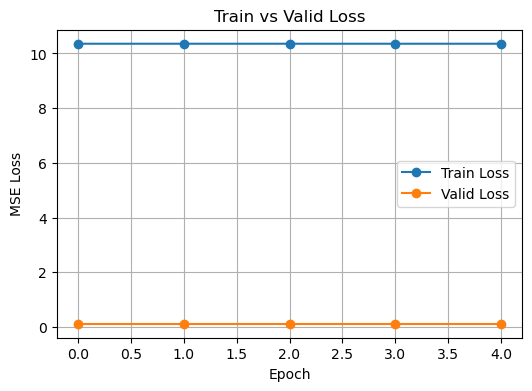

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(train_losses, marker='o', label="Train Loss")
plt.plot(valid_losses, marker='o', label="Valid Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Train vs Valid Loss")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
def evaluate_per_gene(model, loader, device="cuda"):
    model.eval()

    diffs = []

    with torch.no_grad():
        for batch in loader:
            # [수정 1] 5개 변수로 받기 (drug_emb 추가)
            input_ids, values, mask, drug_emb, deltaX_true = batch
            
            input_ids = input_ids.to(device)
            values = values.to(device)
            mask = mask.to(device)
            drug_emb = drug_emb.to(device) # [수정 2] GPU로 이동
            deltaX_true = deltaX_true.to(device)

            # [수정 3] 모델에 drug_emb 입력
            pred = model(input_ids, values, mask, drug_emb)
            
            diff = (pred - deltaX_true).cpu().numpy()
            diffs.append(diff)

    diffs = np.concatenate(diffs, axis=0)    # (N, 5000)
    mse_per_gene = np.mean(diffs**2, axis=0)

    return mse_per_gene

In [25]:
mse_genes = evaluate_per_gene(fr_model, test_loader, device)

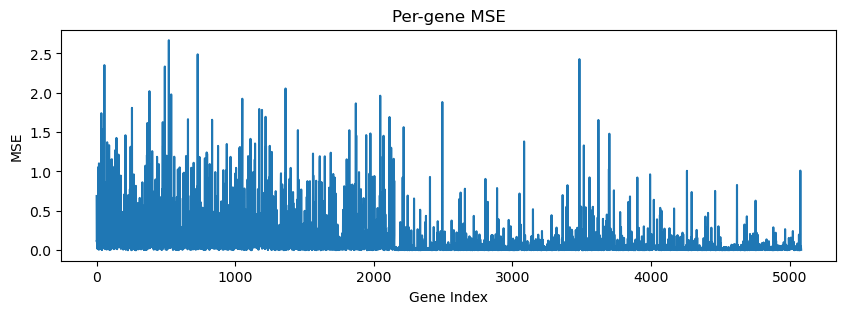

In [26]:
plt.figure(figsize=(10,3))
plt.plot(mse_genes)
plt.title("Per-gene MSE")
plt.xlabel("Gene Index")
plt.ylabel("MSE")
plt.show()

In [27]:
torch.save(fr_model.state_dict(), "model_pearson_064.pt")

In [28]:
# 유전자별 MSE가 담긴 mse_genes를 활용합니다
gene_names = np.array(adata.var_names) # 유전자 이름 리스트

# MSE가 가장 낮은(잘 맞춘) 유전자 Top 20 뽑기
sorted_idx = np.argsort(mse_genes)
best_genes = gene_names[sorted_idx[:20]]
best_mse = mse_genes[sorted_idx[:20]]

print("=== 모델이 가장 잘 예측하는 유전자 Top 20 ===")
for g, m in zip(best_genes, best_mse):
    print(f"{g}: MSE {m:.4f}")

=== 모델이 가장 잘 예측하는 유전자 Top 20 ===
ENSG00000278913: MSE 0.0000
ENSG00000287827: MSE 0.0000
ENSG00000237329: MSE 0.0000
ENSG00000258027: MSE 0.0000
ENSG00000186790: MSE 0.0000
ENSG00000150201: MSE 0.0000
ENSG00000236634: MSE 0.0000
ENSG00000259339: MSE 0.0000
ENSG00000172023: MSE 0.0000
ENSG00000206650: MSE 0.0000
ENSG00000230123: MSE 0.0000
ENSG00000244550: MSE 0.0000
ENSG00000254993: MSE 0.0000
ENSG00000205856: MSE 0.0000
ENSG00000248285: MSE 0.0000
ENSG00000223450: MSE 0.0000
ENSG00000291014: MSE 0.0000
ENSG00000287951: MSE 0.0001
ENSG00000289500: MSE 0.0001
ENSG00000285610: MSE 0.0001


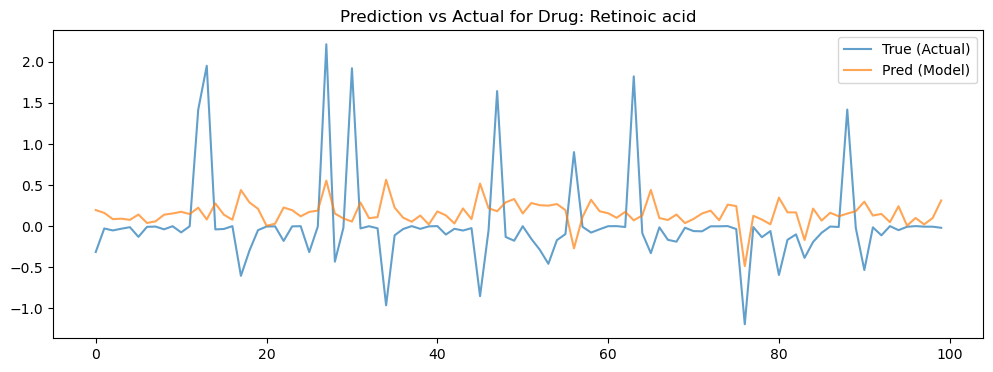

In [29]:
import matplotlib.pyplot as plt

# 테스트 데이터셋에서 샘플 하나 가져오기 (예: 0번째 샘플)
input_ids, values, mask, drug_emb, deltaX_true = test_dataset[0]
drug_name = test_dataset.drug_names[0]

# 모델 예측 (Batch 차원 추가 필요: unsqueeze)
fr_model.eval()
with torch.no_grad():
    input_ids = input_ids.unsqueeze(0).to(device)
    values = values.unsqueeze(0).to(device)
    mask = mask.unsqueeze(0).to(device)
    drug_emb = drug_emb.unsqueeze(0).to(device)
    
    pred = fr_model(input_ids, values, mask, drug_emb)

# 시각화 (첫 100개 유전자만 비교)
plt.figure(figsize=(12, 4))
plt.plot(deltaX_true.numpy()[:100], label="True (Actual)", alpha=0.7)
plt.plot(pred.cpu().numpy()[0][:100], label="Pred (Model)", alpha=0.7)
plt.title(f"Prediction vs Actual for Drug: {drug_name}")
plt.legend()
plt.show()